In [1]:
# Error with scientific format in plot axes
ENV["GKS_ENCODING"] = "utf8"

using Plots
using Printf
using ProfileVega
using Random
using Revise
using Statistics

# The default format SVG creates figures of size 9600x6400
ProfileVega.set_default_size(1200, 800)

Random.seed!(42)

# The default format SVG creates figures of size 9600x6400
gr(fmt="png")
nothing

In [2]:
module MazeWorld

using ReinforcementLearningSutton: GameGridWorldBase, GameGridWorld, I2, T2, dims, state, state_set
import ReinforcementLearningSutton: actions, finished, restart, update

struct Maze
    state_start::I2
    state_goal::I2
    walls::Array{Bool, 2}
    
    function Maze(game0::GameGridWorldBase, pos_start::T2, pos_goal::T2, walls::Array{Bool, 2})
        new(state(game0, pos_start), state(game0, pos_goal), walls)
    end
end

const GameType = GameGridWorld{GameGridWorldBase{T2, T2}, Maze}

actions(game::GameType, state::I2) = game.game0.actions
finished(game::GameType) = (state(game) == game.ruleset.state_goal)
restart(game::GameType) = state_set(game, game.ruleset.state_start)

function update(game::GameType, action::I2)::Int
    maze = game.ruleset
    s0 = state(game)
    
    pos_x = max(1, min(s0.value[1] + action.value[1], dims(game)[1]))
    pos_y = max(1, min(s0.value[2] + action.value[2], dims(game)[2]))
 
    if ~maze.walls[pos_x, pos_y]
        s = state(game, (pos_x, pos_y))
        state_set(game, s)
    end

    finished(game) ? 1 : 0
end

end

Main.MazeWorld

In [3]:
using ReinforcementLearningSutton: GameGridWorldBase, GameGridWorld, LearningDynaQ, PlayerεGreedy, play_game

In [4]:
dims = (9, 6)
pos_start = (1, 3)
pos_goal = (9, 1)

allowed_movements = [(1, 0), (0, 1), (-1, 0), (0, -1)]

maze_walls = zeros(Bool, dims...)
maze_walls[3, 2:4] .= true
maze_walls[6, 5] = true
maze_walls[8, 1:3] .= true

game0 = GameGridWorldBase(dims, allowed_movements)
maze = MazeWorld.Maze(game0, pos_start, pos_goal, maze_walls)
game = GameGridWorld(game0, maze)

permutedims(maze_walls, [2, 1])

6×9 Array{Bool,2}:
 0  0  0  0  0  0  0  1  0
 0  0  1  0  0  0  0  1  0
 0  0  1  0  0  0  0  1  0
 0  0  1  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0

### DynaQ: impact of $n$

In [5]:
ε = 0.1
α = 0.1
γ = 0.95

ns = [0, 5, 50]
max_nsteps = 1000
ngames = 50
navg = 1000

results = zeros(Int, ngames, navg, length(ns))

for (i, n) in enumerate(ns)
    for j in 1:navg
        player = PlayerεGreedy(game, ε)
        learning = LearningDynaQ(player, n, α, γ)
        results[:, j, i] = [play_game(game, player, max_nsteps, learning)[1] for _ in 1:ngames]
    end
end

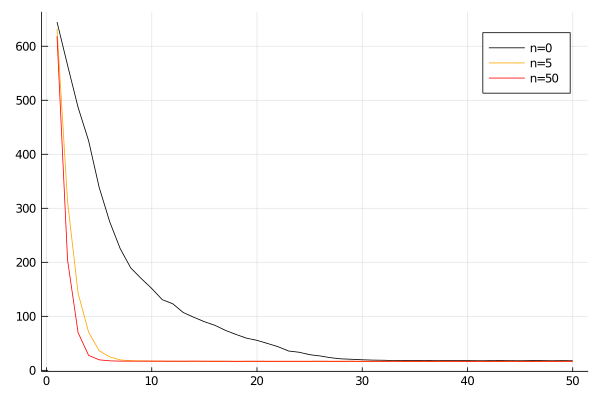

In [6]:
plot(mean(results, dims=2)[:, 1, :], label=["n=0" "n=5" "n=50"], color = [:black :orange :red])

In [7]:
mean(results, dims=[1, 2])[1, 1, :]

3-element Array{Float64,1}:
 100.5295
  39.19326
  34.0045